# Notebook to see about extracting burst duration

## Imports

In [41]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data

## Params

In [42]:
# EXAMPLE DATA INFO
# define identifying info for which data files we'll use here (can also do case by case basis)
mosquito_example_folder = '17_20240507'  # '28_20240529'
mosquito_example_axo = 3  # 0 

drosophila_example_folder = '31_20240611'
drosophila_example_axo = 4


## Helper functions

In [43]:
def realign_spikes(spikes, spike_idx, emg, window, thresh_factor=0.5):
    """
    Helper function to align spike waveform traces based on when they
    first cross a given threshold

    Args:
        spikes: list containing isolated spike waveform arrays (data['spikes'])
        spike_idx: list of indices of detected spikes (data['spike_idx'])
        emg: array containing raw emg data (data['emg'])
        window: int giving the size of spike window to consider
        thresh_factor: number to multiply by mean spike height to get 
            threshold whose crossing we align to

    Returns:
        spikes_realigned:  list containing isolated REALIGNED spike waveforms
        spike_realigned_idx: list of indices of REALIGNED spikes
    
    """
    # calculate thresh based on spike height and thresh_factor
    mean_spike_height = np.mean(np.max(np.vstack(spikes), axis=1))
    thresh = thresh_factor*mean_spike_height  # align waveforms to when spikes cross thresh

    # loop through and get aligned spike arrays
    spikes_realigned = list()
    spike_realigned_idx = list()

    for idx in spike_idx:
        # get spike in current window
        idx_range = np.arange(idx - window, idx + window)
        spike = emg[idx_range]
    
        # subtract off value at initial time point
        spike -= spike[0]
    
        # find first instance of thresh crossing
        try:
            thresh_idx = np.where(spike > thresh)[0][0]
        except IndexError:
            continue
            
        thresh_idx += (idx - window)
        spike_realigned_idx.append(thresh_idx)
    
        # get spike in this new window
        spike_new = emg[slice(thresh_idx - window, thresh_idx + 2*window)]
        spikes_realigned.append(spike_new)

    return spikes_realigned, spike_realigned_idx

In [44]:
def spike_time(time_array, spike_array, fraction = 0.5, debug_flag=False):
    '''
    finding the peak for one spike, then splitting it at the maximal hight into pre and post the peak
    the finding the minimum value before and after the peak
    define the cutoff post the spike as fraction to not include the nitch filter noise after the peak
    then the arrays (positions) are alligned to the samle time to calculate the time in seconds
    then the spike duration/time is calculated via subtracting
        the time from the pre spike minimum to the spike from the time after the peak plus the cutoff position
        which was added with the cutoff position
    the amplitude is calculated via subtracting the peaks pre minimum from the peak
    '''
    # Dealing with the spike array
    # Get the peak spike
    peak = np.max(spike_array)
    peak_posn = np.where(spike_array == peak)[0][-1]
    
    # Split the array
    pre  = spike_array[:peak_posn]
    post = spike_array[peak_posn:]
    
    # Minimum in the pre
    pre_min  = np.min(pre)
    pre_posn = np.where(pre == pre_min)[0][-1]
    
    # Minimum in the post
    post_min  = np.min(post)
    # post_posn = np.where(post == post_min)[0][0]
    
    # Cutoff Value
    diff = np.abs(peak - post_min)
    cutoff_value = peak - (fraction * diff)
    
    # Cutoof Position - Post
    cutoff_posn_post = np.where(post <= cutoff_value)[0][0]

    # Cutoof Position - Pre
    try:
        cutoff_posn_pre = np.where(pre <= cutoff_value)[0][-1]
    except IndexError:
        return np.nan, np.nan
        
    # Matching the spike positions to the times
    time_pre_min  = time_array[cutoff_posn_pre]
    time_post_min = time_array[cutoff_posn_post + peak_posn]
    time_peak     = time_array[peak_posn]
    
    # Spike Time
    spike_duration = time_post_min - time_pre_min
    
    # Amplitude
    amplitude = peak - pre_min

    # debug?
    if debug_flag:
        # make fig and ax
        fig, ax = plt.subplots()

        # plot spike
        ax.plot(time_array, spike_array)

        # plot detected regions
        ax.plot(time_array[cutoff_posn_pre], spike_array[cutoff_posn_pre], 'go', label='pre')
        ax.plot(time_array[peak_posn], spike_array[peak_posn], 'ko', label='peak')
        ax.plot(time_array[cutoff_posn_post + peak_posn], spike_array[cutoff_posn_post + peak_posn], 'ro', label='cutoff')

        ax.set_ylabel('volts')
        ax.set_xlabel('time (s)')
        plt.legend()
        
    return spike_duration, amplitude


## Load data

In [45]:
# load data sets
mosquito_data = load_processed_data(mosquito_example_folder, mosquito_example_axo)
drosophila_data = load_processed_data(drosophila_example_folder, drosophila_example_axo)

In [46]:
# get MOSQUITO spike durations
window = round(mosquito_data['params']['emg_window']/2)
fs = mosquito_data['sampling_freq']
mosquito_spikes, _ = realign_spikes(mosquito_data['spikes'], 
                                    mosquito_data['spike_idx'], 
                                    mosquito_data['emg'],
                                    window,
                                    thresh_factor=0.25)
mosquito_t = (1/fs)*(np.arange(mosquito_spikes[0].shape[0]) - window)
mosquito_t -= mosquito_t[0]

mosquito_durations = list()
mosquito_amplitudes = list()

for spike in mosquito_spikes:
    dur, amp = spike_time(mosquito_t, spike)
    if not np.isnan(dur):
        mosquito_durations.append(dur)
        mosquito_amplitudes.append(amp)


In [47]:
# get DROSOPHILA spike durations
window = round(drosophila_data['params']['emg_window']/2)
fs = drosophila_data['sampling_freq']
drosophila_spikes, _ = realign_spikes(drosophila_data['spikes'], 
                                    drosophila_data['spike_idx'], 
                                    drosophila_data['emg'],
                                    window,
                                    thresh_factor=0.25)
drosophila_t = (1/fs)*(np.arange(drosophila_spikes[0].shape[0]) - window)
drosophila_t -= drosophila_t[0]

drosophila_durations = list()
drosophila_amplitudes = list()

for spike in drosophila_spikes:
    dur, amp = spike_time(drosophila_t, spike)
    if not np.isnan(dur):
        drosophila_durations.append(dur)
        drosophila_amplitudes.append(amp)


Mosquito median FWHM:  0.01604582893949326
Drosophila median FWHM:  0.0024795508307920294


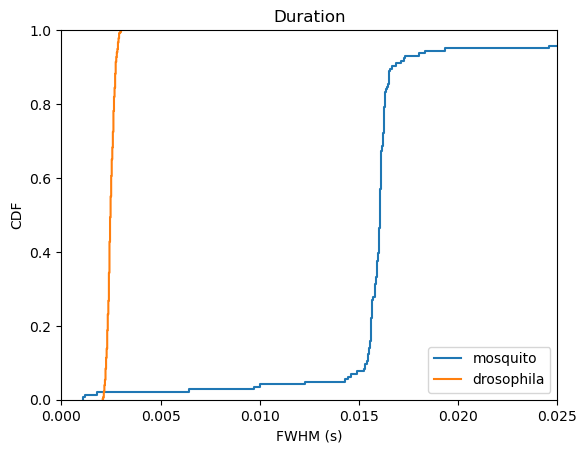

In [48]:
# plot CDFs of durations
fig, ax = plt.subplots()

# plot cdfs
ax.ecdf(mosquito_durations, label='mosquito')
ax.ecdf(drosophila_durations, label='drosophila')

# label axes
ax.set_xlabel('FWHM (s)')
ax.set_ylabel('CDF')
ax.set_title('Duration')

# # set axis limits
ax.set_xlim([0, 0.025])

# make legend
plt.legend()

# print median values
print('Mosquito median FWHM: ', np.median(np.asarray(mosquito_durations)))
print('Drosophila median FWHM: ', np.median(np.asarray(drosophila_durations)))

Mosquito median amplitude:  0.2468872
Drosophila median amplitude:  1.3748169


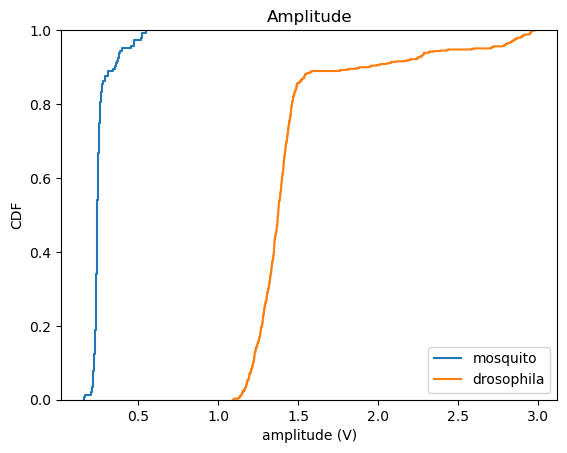

In [50]:
# plot CDFs of amplitude
fig, ax = plt.subplots()

# plot cdfs
ax.ecdf(mosquito_amplitudes, label='mosquito')
ax.ecdf(drosophila_amplitudes, label='drosophila')

# label axes
ax.set_xlabel('amplitude (V)')
ax.set_ylabel('CDF')
ax.set_title('Amplitude')

# make legend
plt.legend()

# print median values
print('Mosquito median amplitude: ', np.median(np.asarray(mosquito_amplitudes)))
print('Drosophila median amplitude: ', np.median(np.asarray(drosophila_amplitudes)))

## Spike duration check


(0.01621683244506512, 0.2923584)

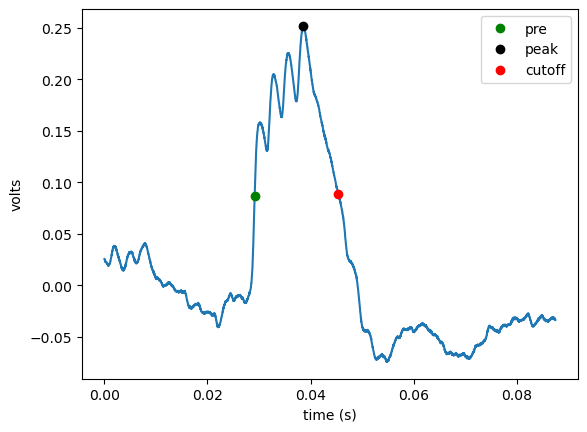

In [32]:
# look at mosquito spike duration detection
ex_ind = 3
spike_time(mosquito_t, mosquito_spikes[ex_ind], debug_flag=True)

(0.0022515461566962117, 2.2836304)

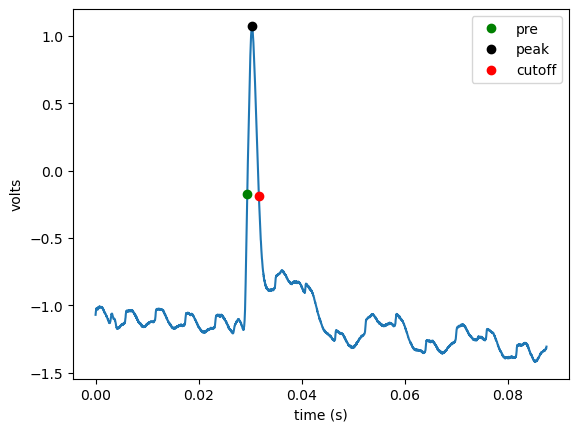

In [21]:
# look at Drosophila spike duration detection
ex_ind = 45
spike_time(drosophila_t, drosophila_spikes[ex_ind], debug_flag=True)